In [1]:
#! pip install -q tensorflow-model-optimization
#! pip install tensorflow-addons

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from LTH_helper import LTH

https://arxiv.org/abs/1803.03635

https://www.youtube.com/watch?v=0VH1Lim8gL8&feature=youtu.be&t=2760

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
import os
import random as rn
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow_model_optimization as tfmot
from tensorflow.keras import initializers

In [5]:
def set_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)
    # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    # K.set_session(sess)

# Cargo datos

In [6]:
folder = './'

In [7]:
X = np.load(folder+'train_images.npy').reshape(-1, 784)/255
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1).reshape(-1, 1)
X_test = np.load(folder+'test_images.npy').reshape(-1, 784)/255
y_test = pd.read_csv(folder+'test_labels.csv')['Category'].values

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Red neuronal básica

In [9]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [10]:
def get_model(compile_model_flag=True, lr=0.001):
    reduce = 2
    input_dim=784
    output_size = 10
    # Creo el modelo
    model = Sequential()
    model.add(Dense(784*2//reduce, activation='linear', name='hidden_1', kernel_initializer=initializers.glorot_uniform(),
                    input_dim=input_dim))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(784//reduce, activation='linear', name='hidden_2', kernel_initializer=initializers.glorot_uniform(),
                   ))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(output_size, name='Salida', kernel_initializer=initializers.glorot_uniform(),
                   ))
    model.add(Activation('softmax'))
    if compile_model_flag:
        compile_model(model, lr=lr)
    return model
model = get_model()
# model.save_weights('random-init.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 784)               615440    
_________________________________________________________________
activation (Activation)      (None, 784)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 392)               307720    
_________________________________________________________________
activation_1 (Activation)    (None, 392)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                3930      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 927,090
Trainable params: 927,090
Non-trainable params: 0
__________________________________________________

In [11]:
lth = LTH(get_model)

![LTH_alg.png](LTH_alg.png)

# Step 1 and 2. Initialize and Train network

In [12]:
def get_callbacks(filename):
    return [
        ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=np.sqrt(0.1), patience=10, verbose=1, min_lr=1e-4),
        ModelCheckpoint(filepath=filename,  verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
    ]

In [13]:
batch_size = 256
epochs = 100

In [14]:
# Step 1 
model = get_model()
# Save initial weights
model.save_weights('mlp.mnist.initial_weights.hdf5')
history_1 = model.fit(X_train, 
           y_train,
           epochs=epochs, batch_size=batch_size, 
           validation_data = (X_val, y_val),
           verbose=2, 
           callbacks=get_callbacks('mlp.mnist.first_train.hdf5')
          )

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.84578, saving model to mlp.mnist.first_train.hdf5
200/200 - 1s - loss: 0.5139 - accuracy: 0.8203 - val_loss: 0.4206 - val_accuracy: 0.8458 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.84578 to 0.85522, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.3614 - accuracy: 0.8702 - val_loss: 0.3975 - val_accuracy: 0.8552 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.85522 to 0.87789, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.3272 - accuracy: 0.8792 - val_loss: 0.3347 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.87789 to 0.87867, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.2971 - accuracy: 0.8880 - val_loss: 0.3347 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.87867 to 0.88689, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - 

In [15]:
model.evaluate(X_val, y_val, verbose=0)

[0.8580614924430847, 0.9005555510520935]

In [16]:
model.load_weights('mlp.mnist.first_train.hdf5')
print(model.evaluate(X_val, y_val, verbose=0), model.evaluate(X_test, y_test, verbose=0))

[0.68180251121521, 0.9024444222450256] [0.7717013955116272, 0.9003999829292297]


# Step 3. Get Trainned pruned model

In [17]:
# Get prunned model with correct mask
pm = 0.5 # Porcentage of weights not pruned
model_pruned_trained = lth.get_prunned_model('mlp.mnist.first_train.hdf5', pm)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [18]:
model_pruned_trained.evaluate(X_test, y_test)

313/313 [==============================] - 0s 798us/step - loss: 0.6945 - accuracy: 0.8969


[0.6945029497146606, 0.8968999981880188]

In [19]:
# model_initialized = lth.initialize_sparse_model('mlp.mnist.first_train.hdf5', model_pruned_layers_trained, pm)
# model_initialized.evaluate(X_test, y_test)

In [20]:
#lth.verify_mask_with_model_min_weights('mlp.mnist.first_train.hdf5', model_pruned_layers_trained)

In [21]:
# It has to be false beacuase the model is not trained
# lth.verify_mask_with_model_min_weights('mlp.mnist.initial_weights.hdf5', model_pruned_layers_trained)

# Step 4. Prune initial random weights

In [22]:
pruned_model_not_trained = lth.initialize_sparse_model('mlp.mnist.initial_weights.hdf5', model_pruned_trained, pm)
# lth.test_model_sparsity(pruned_model_not_trained)
# print(f'Acc: {pruned_model_not_trained.evaluate(X_test, y_test, verbose=0)[1]}, Sparcity: {l1_sparc}')

In [23]:
# lth.verify_mask_with_model_min_weights(pruned_model, model_pruned_layers_trained)

# Train pruned model

In [24]:
def get_prunned_callbacks(filename):
    return get_callbacks(filename) + [tfmot.sparsity.keras.UpdatePruningStep()]

In [25]:
compile_model(pruned_model_not_trained)
history_2 = pruned_model_not_trained.fit(X_train, 
               y_train,
               epochs=epochs, batch_size=batch_size, 
              validation_data = (X_val, y_val),
               verbose=2, 
                    shuffle = True,
                           callbacks=get_prunned_callbacks('mlp.mnist.sparse_train.hdf5')
              )

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.84911, saving model to mlp.mnist.sparse_train.hdf5
200/200 - 1s - loss: 0.5773 - accuracy: 0.8033 - val_loss: 0.4241 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.84911 to 0.86378, saving model to mlp.mnist.sparse_train.hdf5
200/200 - 1s - loss: 0.3873 - accuracy: 0.8628 - val_loss: 0.3881 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.86378 to 0.87933, saving model to mlp.mnist.sparse_train.hdf5
200/200 - 1s - loss: 0.3387 - accuracy: 0.8784 - val_loss: 0.3429 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.87933 to 0.87956, saving model to mlp.mnist.sparse_train.hdf5
200/200 - 1s - loss: 0.3079 - accuracy: 0.8870 - val_loss: 0.3397 - val_accuracy: 0.8796 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.87956 to 0.88189, saving model to mlp.mnist.sparse_train.hdf5
200/200 - 

In [26]:
pruned_model_not_trained.evaluate(X_val, y_val, verbose=0)

[0.7561230063438416, 0.9007777571678162]

In [27]:
pruned_model_not_trained.load_weights('mlp.mnist.sparse_train.hdf5')
print(pruned_model_not_trained.evaluate(X_val, y_val, verbose=0))
pruned_model_not_trained.evaluate(X_test, y_test, verbose=0)

[0.5385008454322815, 0.9039999842643738]


[0.5790573358535767, 0.8988999724388123]

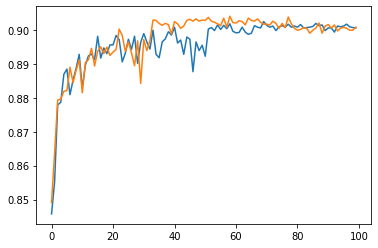

In [28]:
plt.plot(history_1.history['val_accuracy'])
plt.plot(history_2.history['val_accuracy'])

# Re-train reducing pm

In [29]:
# Pruned layer to Dense
trained_striped_model = tfmot.sparsity.keras.strip_pruning(pruned_model_not_trained)
# Save weights
trained_striped_model.save_weights('mlp.mnist.sparse_train_striped.hdf5')

In [30]:
new_pm = pm**(1/2)*pm
print(new_pm)

0.3535533905932738


In [31]:
pruned_model_2 = lth.get_prunned_model('mlp.mnist.sparse_train_striped.hdf5', new_pm)

In [32]:
untrained_pruned_model_2 = lth.initialize_sparse_model('mlp.mnist.initial_weights.hdf5', pruned_model_2, new_pm)
compile_model(pruned_model_2)

In [33]:
history_3 = pruned_model_2.fit(X_train, 
               y_train,
               epochs=epochs, batch_size=batch_size, 
              validation_data = (X_val, y_val),
               verbose=2, 
                    shuffle = True,
                           callbacks=get_prunned_callbacks('mlp.mnist.sparse_train_2.hdf5')
              )

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.89389, saving model to mlp.mnist.sparse_train_2.hdf5
200/200 - 1s - loss: 0.0399 - accuracy: 0.9855 - val_loss: 0.5500 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.89389 to 0.89444, saving model to mlp.mnist.sparse_train_2.hdf5
200/200 - 0s - loss: 0.0369 - accuracy: 0.9868 - val_loss: 0.5390 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.89444 to 0.89544, saving model to mlp.mnist.sparse_train_2.hdf5
200/200 - 1s - loss: 0.0399 - accuracy: 0.9851 - val_loss: 0.5446 - val_accuracy: 0.8954 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.89544 to 0.89900, saving model to mlp.mnist.sparse_train_2.hdf5
200/200 - 1s - loss: 0.0314 - accuracy: 0.9889 - val_loss: 0.5365 - val_accuracy: 0.8990 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_accuracy did not improve from 0.89900
200/200 - 0s - loss: 0.0307 - accuracy: 0.9886 - va

In [34]:
pruned_model_2.load_weights('mlp.mnist.sparse_train_2.hdf5')
print(pruned_model_2.evaluate(X_val, y_val, verbose=0))
pruned_model_2.evaluate(X_test, y_test, verbose=0)

[0.792011022567749, 0.9039999842643738]


[0.86404949426651, 0.8998000025749207]

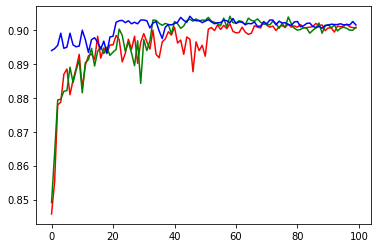

In [35]:
plt.plot(history_1.history['val_accuracy'], c='r')
plt.plot(history_2.history['val_accuracy'], c='g')
plt.plot(history_3.history['val_accuracy'], c='b')